# Generative RNN in Browser

This chapter builds on the model and information presented in {doc}`../dl/NLP`. We'll see how to develop, train, and deploy a model to a website. The goal is to develop a model that can propose new molecules. A "molecule" is a broad term, so we'll restrict ourselves to molecules like those that might be used for a small molecule drug. There is an existing database for this task called [ZINC](http://zinc15.docking.org/) (recursive acronym: *ZINC is not commercial*). The ZINC database contains 750 million molecules (as SMILES) that **can be purchased directly**. By training with ZINC, you are restricting your training distribution to molecules that can be synthesized.{cite}`sterling2015zinc`

750 million molecules is often enough. Instead of generating new molecules with a model, you can just sample from ZINC and be assured that each molecule is purchasable. Sometimes that is not possible because we're more interested in building a representation (a vector for each molecule), rather than actually sampling like in self-supervised learning. My recommendation in projects is to strongly consider just using ZINC directly if possible. We'll continue on for our approach, because we may go on to use the RNN for "downstream tasks" like predicting solubility using the self-supervised trained RNN.

You can see the final idea of what we're trying to accomplish in this chapter at [whitead.github.io/molecule-dream/](https://whitead.github.io/molecule-dream/). This model was generated using our final code at the bottom. 

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages, either on your own environment or on Google Colab

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell

```
!pip install matplotlib numpy tensorflow pandas seaborn rdkit-pypi selfies tensorflowjs
```

````

## Approach 1: Token Sampling

At first, it may seem simple to generate new molecules. Any sequence of SELFIES is a valid molecule {cite}`krenn2020self`. Let's start by trying this approach -- making random sequences. Recall that a sequence is an array of tokens, like characters or words. In SELFIES, the tokens are very clear because they are enclosed by square brackets. For example,`[C][C]` is a SELFIES sequence with two tokens. 

We want to generate new molecules similar to ZINC remember, so we'll start by extracting all unique tokens from that database. To save everyone a little time, we'll work with a subset of ZINC that has about 250,000 molecules that comes from the SELFIES repo.

In [54]:
import selfies as sf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
from dataclasses import dataclass
import seaborn as sns
np.random.seed(0)
IPythonConsole.ipython_useSVG = True
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 })
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 

In [2]:
data_url = 'https://github.com/aspuru-guzik-group/selfies/raw/16a489afa70882428bc194b2b24a2d33573f1651/examples/vae_example/datasets/dataJ_250k_rndm_zinc_drugs_clean.txt'
pd_data = pd.read_csv(data_url)
print('Total data size', len(pd_data))

Total data size 249455


We now have our starting dataset. To extract the SELFIES tokens, we need to convert the dataset (which is in SMILES) into SELFIES. This might take a while...

In [3]:
selfies_list = [sf.encoder(s) for s in  pd_data.iloc[:,0]]

Here's what one of the examples look like:

In [4]:
print(selfies_list[0])

[C][C@@Hexpl][C][C][Branch2_1][Ring1][Ring2][N][C][=C][N][=C][C][Branch1_1][Branch2_2][C][=N][N][=C][N][Ring1][Branch1_1][C][=C][Ring1][N][C][C@@Hexpl][Branch1_1][C][C][C][Ring2][Ring1][Ring2]


Let's extract now all the possible tokens and count them. I'll initialize my list with the '[nop]' token, which is the SELFIES null token we'll use later for padding. 

In [5]:
selfies_symbol_counts = {'[nop]': 0}
def parse(s):    
    for si in s.split('[')[1:]:
        token = '[' + si
        if token in selfies_symbol_counts:
            selfies_symbol_counts[token] += 1
        else:
            selfies_symbol_counts[token] = 0
[parse(s) for s in  selfies_list]

# print out topic tokens
sorted_token_counts = list(sorted(selfies_symbol_counts.items(), key=lambda i: -i[1]))
for p in sorted_token_counts[:10]:
    print(*p)

[C] 3535514
[=C] 1122876
[Ring1] 857002
[Branch1_1] 621378
[Branch1_2] 523333
[N] 510053
[=O] 318168
[O] 279513
[Branch2_1] 202227
[Ring2] 176665


We'll finish up parsing by creating a dictionary to go back from string to index and a list for our vocab.

In [6]:
vocab = list(selfies_symbol_counts.keys())
vocab_stoi = {o:i for o,i in zip(vocab, range(len(vocab)))}

def selfies2ints(s):
    result = []
    for si in s.split('[')[1:]:
        result.append(vocab_stoi['[' + si])
    return result
def ints2selfies(v):
    return ''.join([vocab[i] for i in v])

# test them out
s = selfies_list[0]
print('selfies:', s)
v = selfies2ints(s)
print('selfies2ints:', v)
so = ints2selfies(v)
print('ints2selfes:', so)
assert so == s

selfies: [C][C@@Hexpl][C][C][Branch2_1][Ring1][Ring2][N][C][=C][N][=C][C][Branch1_1][Branch2_2][C][=N][N][=C][N][Ring1][Branch1_1][C][=C][Ring1][N][C][C@@Hexpl][Branch1_1][C][C][C][Ring2][Ring1][Ring2]
selfies2ints: [1, 2, 1, 1, 3, 4, 5, 6, 1, 7, 6, 7, 1, 8, 9, 1, 10, 6, 7, 6, 4, 8, 1, 7, 4, 6, 1, 2, 8, 1, 1, 1, 5, 4, 5]
ints2selfes: [C][C@@Hexpl][C][C][Branch2_1][Ring1][Ring2][N][C][=C][N][=C][C][Branch1_1][Branch2_2][C][=N][N][=C][N][Ring1][Branch1_1][C][=C][Ring1][N][C][C@@Hexpl][Branch1_1][C][C][C][Ring2][Ring1][Ring2]


Now we'll try sampling directly from the tokens. I'm not very good at inferring if a SELFIES string is a reasonable molecule, so we'll render a few using rdkit.

In [7]:
def model1():
    # pick random length
    length = np.random.randint(1,100)
    seq = np.random.choice(len(vocab), size=length)
    return seq

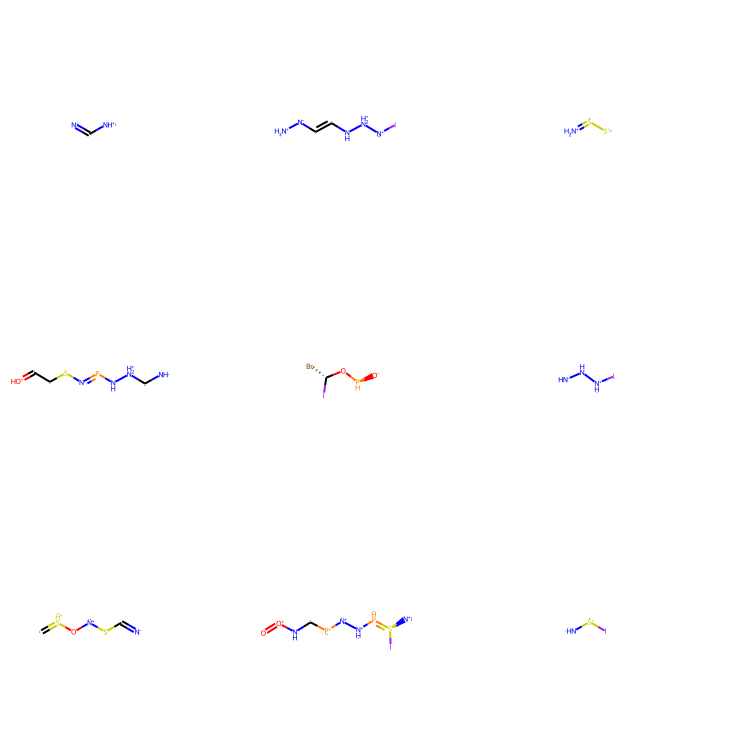

In [55]:
def draw_examples(model, count=10):
    examples = [ints2selfies(model()) for _ in range(9)]
    examples_smiles = [sf.decoder(s) for s in examples]
    from rdkit.Chem import rdDepictor
    examples_mols = [rdkit.Chem.MolFromSmiles(s) for s in examples_smiles]
    return rdkit.Chem.Draw.MolsToGridImage(examples_mols,molsPerRow=3,subImgSize=(250,250))
    
draw_examples(model1)

As you can see, these molecules are a bit extreme -- we see bizarre valences and highly unusual combinations of elements. We can try to sample now according to the frequency of tokens we saw in the corpus (ZINC smiles).

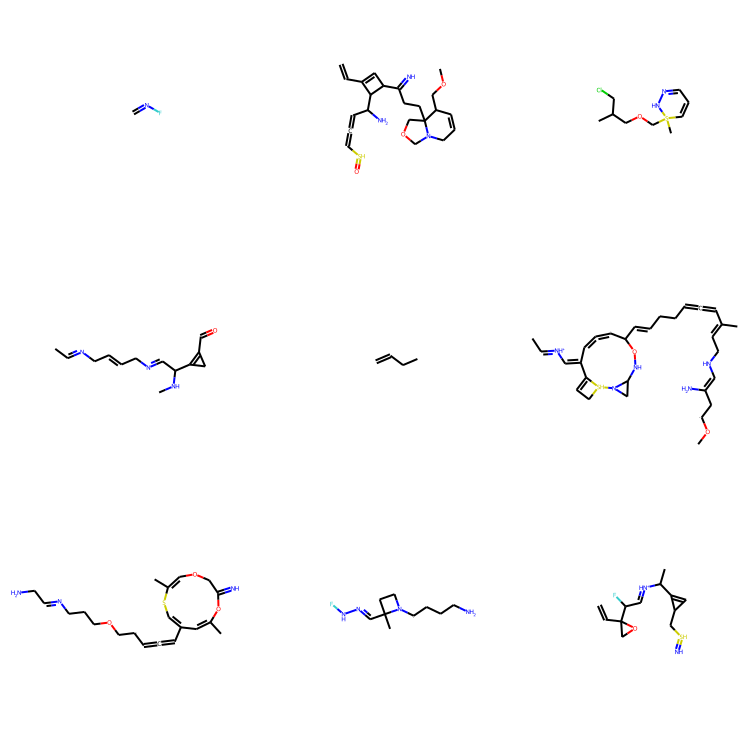

In [56]:
# get sorted token counts to be order
# same as vocab
token_counts = [x[1] for x in sorted(sorted_token_counts, key=lambda i: vocab_stoi[i[0]])]
token_counts = np.array(token_counts)
def model2():
    # pick random length
    length = np.random.randint(1,100)
    seq = np.argmax(np.random.multinomial(1, token_counts / np.sum(token_counts), size=length), axis=-1)
    return seq
# now draw
draw_examples(model2)

These are much better! Still, they are very exotic -- if they could even be synthesized they would probably explode if you sneezed on them. The advantage of SELFIES over SMILES is that none of these were invalid. Just a bit unreasonable.

## Approach 2: Token RNN

Our next approach will be to use a recurrent neural network as we did in {doc}`../dl/NLP`. We will make one major change. The RNN will be trained to predict a whole sequence instead of one value (like solubility). This training process is called self-supervised. We create labels, from splitting up the training data, so it is not exactly unsupervised.

The way we implement self-supervised training with an RNN is that we feed it a sequence up to position $i-1$ and then ask it to predict the sequence value at position $i$. Then at inference time, we feed its output at $i - 1$ as the input to $i$. There are a few tricks to make this efficient. The first is that if we split our data into all possible pairs of training labels (sequence up to $i - 1$) and labels (value at $i$), we'll have $N\times L$ examples which in our case is about 100 million. To treat this, we'll consider the predicted label to be the whole sequence $\vec{\hat{y}}$  and that will include each individual prediction challenge. For example, predicting $\hat{y}$ given $x_0, x_1, x_2$ will be the value of $\vec{\hat{y}}$ at index 3.

You'll notice there is a bit of a length mismatch with this approach. What would $\hat{y}_0$ correspond to? You might say it is the predicted label without any input features, but RNNs require an input to have an output. Instead, we'll prefix every sequence with the special `[nop]` token which means do nothing. Then $\hat{0}$ will be the prediction given a `[nop]` token. We just need to remember at inference time we need to always begin with the `[nop]` token to match the training conditions. 

Let's start by building our training set using the splitting process. I'm going to define all my hyperparameters in one place as well, so I can easily view them. These hyperparameters are mostly first guesses built from previous experience with GRUs for sequence modeling. 

In [10]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int
        
config = Config(vocab_size=len(vocab), 
                example_number=len(selfies_list), 
                batch_size=64, 
                buffer_size=10000, 
                embedding_dim=256, 
                rnn_units=128)

### Data Construction

In [11]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list]
# Keras pads with 0s - [nop] in our vocab
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')

# Now build dataset
seqs_data = tf.data.Dataset.from_tensor_slices((padded_seqs,))

def split_input_target(sequence):
    # remove last input (since no label exists)
    # prefix with [nop]
    input_text = tf.concat(([0], sequence[:-1]), 0)
    target_text = sequence
    return input_text, target_text

In [12]:
data = seqs_data.map(split_input_target)
data = data.shuffle(config.buffer_size).batch(config.batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
# grab examples
for d in data:
    example = d[0]
    example_y = d[1]
    break

### Model Construction

Our model will be the same as {doc}`../dl/NLP`: an embedding, one RNN (GRU variant), and one dense layer. The dense layer could be omitted if an even simpler model was desired. We do not add a softmax to the dense layer because we'll be working with logits instead of probability in training and inference. One change is that we specify the `return_sequences` since we're training across sequences. The other flags to {obj}`tf.keras.layers.GRU` are to set-up for deploying the model to javascript, which we'll see below.

In [13]:
x = tf.keras.Input(shape=(None,))
ex = tf.keras.layers.Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True)(x)
# reset_after - TFJS requires this as false
h = tf.keras.layers.GRU(config.rnn_units, return_sequences=True, reset_after=False, stateful=False)(ex)
yhat = tf.keras.layers.Dense(config.vocab_size)(h)
train_model = tf.keras.Model(inputs=x, outputs=yhat)

Now we'll call it once to make sure it works and to enable Keras to set all the unknown dimensions.

In [14]:
yhat = train_model(example)
train_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         27648     
_________________________________________________________________
gru (GRU)                    (None, None, 128)         147840    
_________________________________________________________________
dense (Dense)                (None, None, 108)         13932     
Total params: 189,420
Trainable params: 189,420
Non-trainable params: 0
_________________________________________________________________


### Training

Now we will train the model. We use a special loss function {obj}`tf.losses.SparseCategoricalCrossentropy` that works on a sequence of logits for computing cross-entropy in the multi-class setting (multi-class because we have multiple possible tokens). I will train for only 2 epochs to reduce the runtime of this notebook, but I've found ~4 is a reasonable balance of time and loss. 

In [15]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
train_model.compile(tf.optimizers.Adam(1e-2), loss=loss)
result = train_model.fit(data, epochs=2, verbose=0)

### Inference

In the inference setting, we need to feed the output from each step back into the model to generate the next token. RNNs are defined by the input and their **state vector** (or state vectors for LSTM). To ensure our model is not forgetting about the tokens it has seen so far, we could keep the state and last output token to use as input to the model. However, an easier approach is to make the underlying model **stateful**. That means its state will be stored as a kind of internal weight and we do not need to bother with passing around the state vector. 

We'll construct a second model that is stateful and make its weights equal to the one we trained. Another change is that we do not need the model to output the whole sequence since we're generating one token at a time. 

In [16]:
x = tf.keras.Input(shape=(None,), batch_size=1)
ex = tf.keras.layers.Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True)(x)
h = tf.keras.layers.GRU(config.rnn_units, return_sequences=False, reset_after=False, stateful=True)(ex)
yhat = tf.keras.layers.Dense(config.vocab_size)(h)
inference_model = tf.keras.Model(inputs=x, outputs=yhat)

# now copy over weights
inference_model.set_weights(train_model.get_weights())

To try the model, remember we start with the `[nop]` token which is zero.

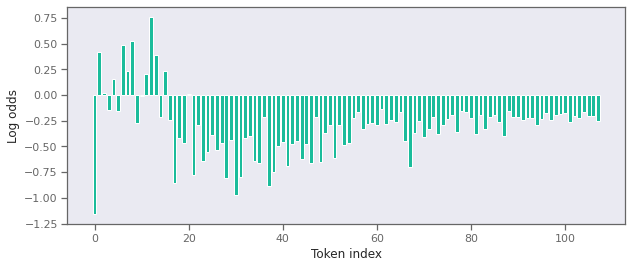

In [61]:
plt.figure(figsize=(10,4))
x = np.array([0])
v = inference_model.predict(x)
plt.bar(x=np.arange(config.vocab_size), height=np.squeeze(v))
plt.xlabel('Token index')
plt.ylabel('Log odds')
plt.show()

This is the logit probability for each token. We need to sample from this to get our prediction for the first token. We'll sample it with an adjustable parameter called **temperature**. Temperature controls how close we are to sampling the maximum. $T = 0$ means we sampling the max only, $T = 1$ means we sample according to the logits, and $T = \infty$ means we sample randomly.

In [18]:
def sample_token(x, T=1):
    return tf.random.categorical(x / T, 1)
t = sample_token(v)
print(t)

tf.Tensor([[1]], shape=(1, 1), dtype=int64)


Now to continue we feed back into the stateful model. Let's wrap this into a function.

In [19]:
def sample_model(T=1):
    length = np.random.randint(1,100)
    seq = []
    x = tf.zeros((1,))
    # reset stateful model
    inference_model.reset_states()    
    for _ in range(length):
        v = inference_model.predict(x)
        x = sample_token(v, T)   
        seq.append(int(np.squeeze(x.numpy())))
    return seq

We'll draw the output for $T = 1$

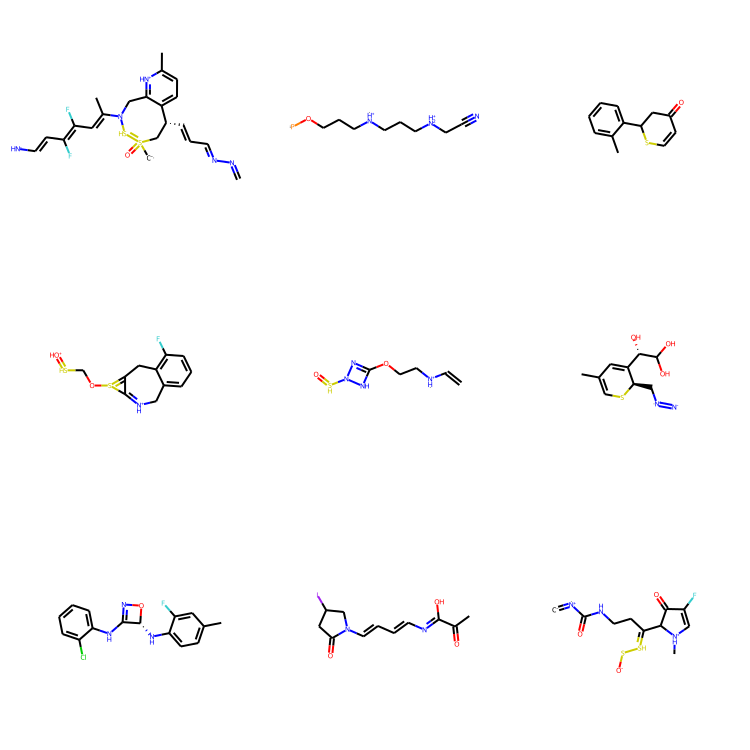

In [62]:
draw_examples(sample_model)

These are better still! Now we can try adjusting the temperature to see more unusual or more common molecules

$T = 0.5$

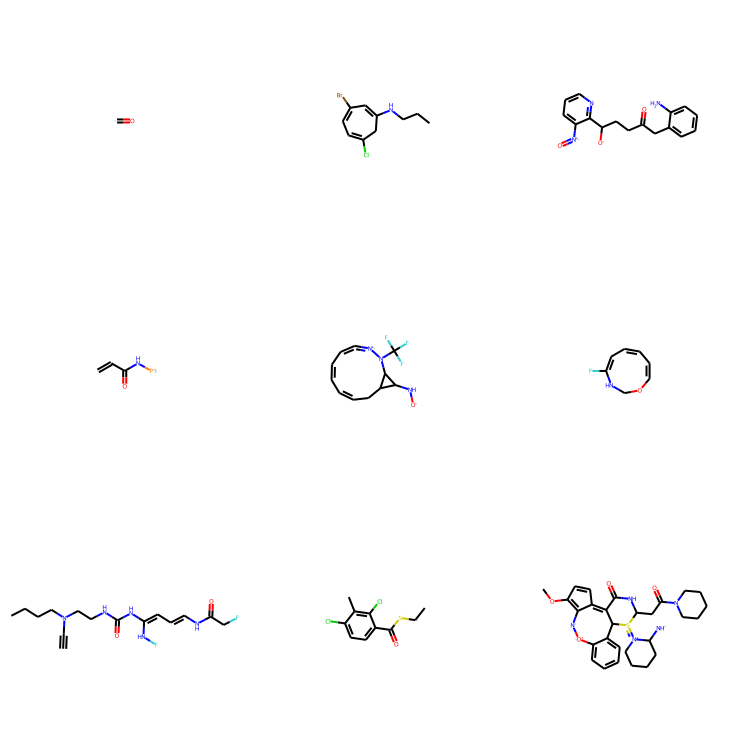

In [63]:
draw_examples(lambda : sample_model(T=0.5))

$T = 100$

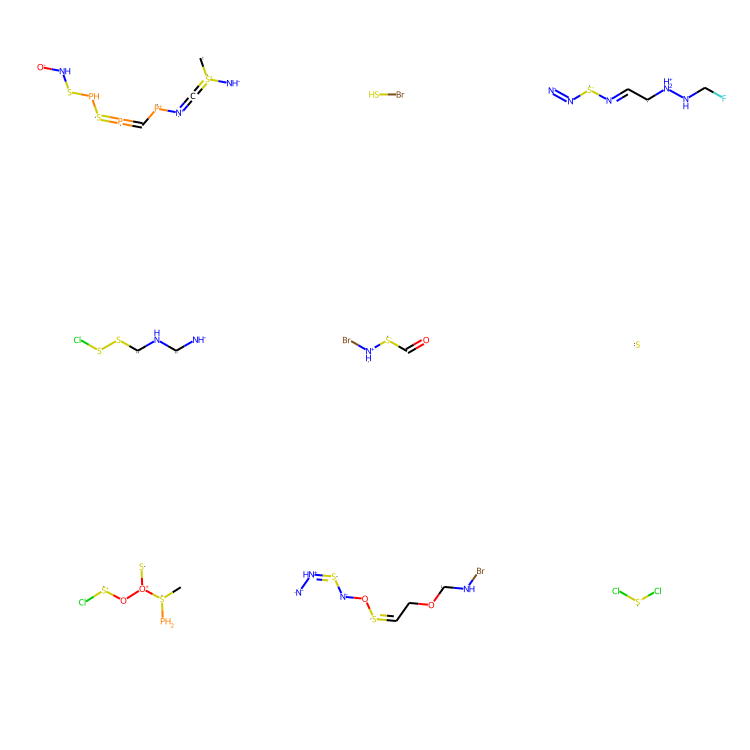

In [64]:
draw_examples(lambda : sample_model(T=100))

You can see that the $T = 0.5$ case seems to works the best of the three.

## Model Deployment

Finally, to get the model into javascript as shown at [Molecule Dream](https://whitead.github.io/molecule-dream/) we can export using tensorflowjs. It is relatively simple, but you may notice when you load the model into javascript that console errors may indicate you need to adjust flags in model construction.


In [23]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(inference_model, 'tfjs_model')

I also like to save the config in case I need to know things like the vocab or dimension of the vectors. JSON files can be easily loaded into javascript objects.

In [24]:
import json
from dataclasses import asdict

model_info = asdict(config)
model_info['stoi'] = vocab_stoi
model_info['vocab'] = vocab


with open('tfjs_model/config.json', 'w') as f:
    json.dump(model_info, f)

We'll start by seeing how we load the model code. This section requires some knowledge of javascript. This javascript code loads the model and config JSON file. Then it creates two functions - `model(t)` and `resetStates()` which are the two ways we use our model. 

```js
import * as tf from '@tensorflow/tfjs';
import config from 'tfjs_model/config.json;

const rnn_mod = {}

const loader = tf.loadLayersModel('/tfjs_model/model.json');
loader.then((model) => {
    rnn_mod.model = (t) => {
        return model.predict(t);
    }
    rnn_mod.resetStates = () => {
        model.resetStates();
    }
});
```

Next we need a few helper functions that we used for inference. These are sampling and for converting from integers to the SELFIES tokens.

```js
rnn_mod.sample = (x, seed, T = 0.1, k = 1) => {
    return tf.multinomial(
        tf.mul(tf.scalar(2.0), x), k, seed
    );
}

rnn_mod.selfie2vec = (s) => {
    const vec = tf.tensor(s.split('[').slice(1).map((e, i) => {
        if (e)
            parseInt(config.stoi['[' + e]);
    }));
    return vec;
}

rnn_mod.initVec = () => {
    return tf.tensor([0]);
}

rnn_mod.vec2selfie = (v) => {
    const out = v.array().then((x) => {
        if (Array.isArray(x)) {
            return x.map((e, i) => {
                return config.vocab[parseInt(e)];
            });
        } else {
            return [config.vocab[parseInt(x)]];
        }
    });

    return out;
}

export default rnn_mod;
```

This code gives us a javascript module that can then be used for sampling from our trained model. See the [Molecular Dream repo](https://github.com/whitead/molecule-dream/) for the complete code. 

## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```